# Non-Personalized recommeder systems


A non-personalized recommender system is one that makes the **same recommendations for everyone.**

The simplest example is a retailer that shows the ten (or some number) most popular products on their homepage. 

Some examples:

### IMDB: MOVIE RANKING
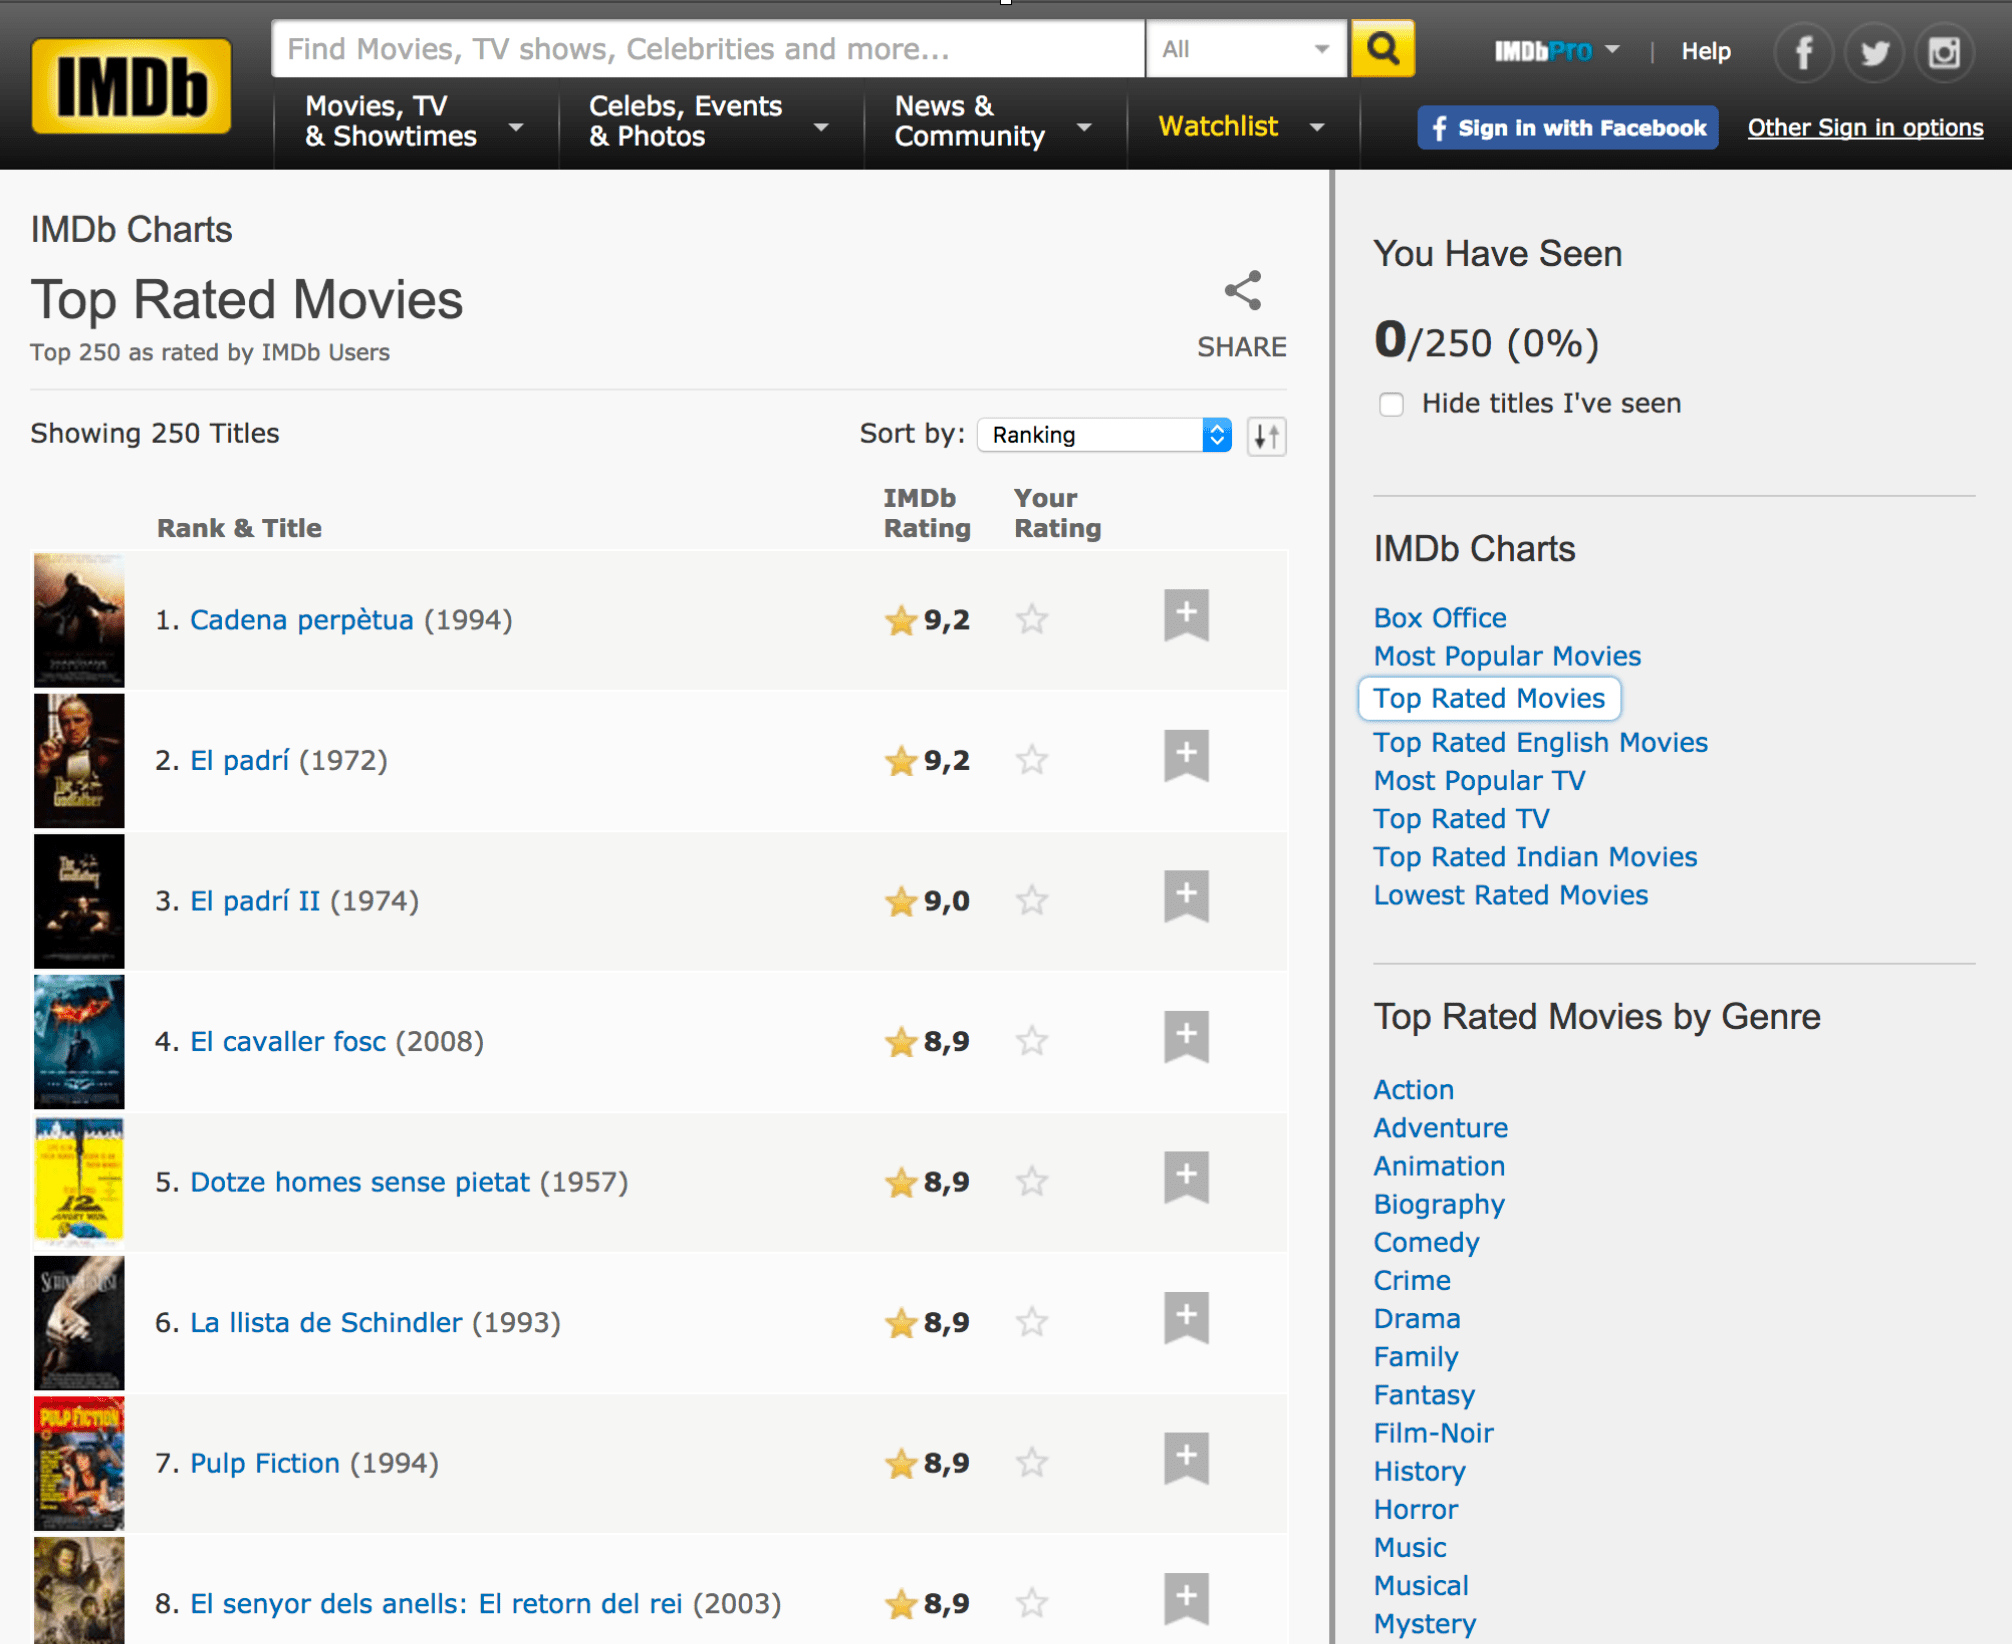

### Amazon: Top Recommendations
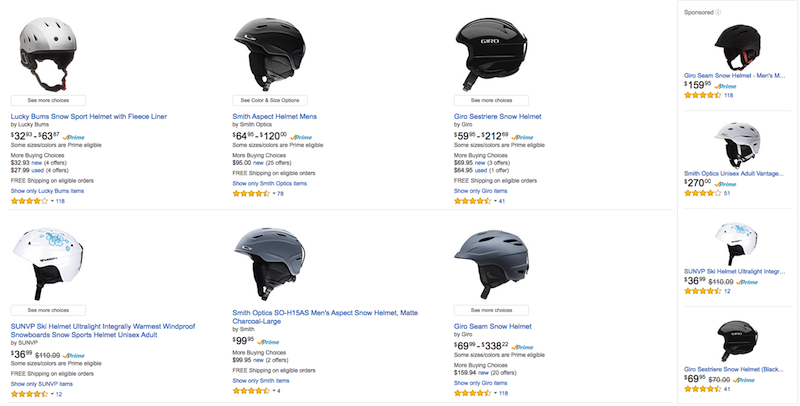

### Amazon: Product Association
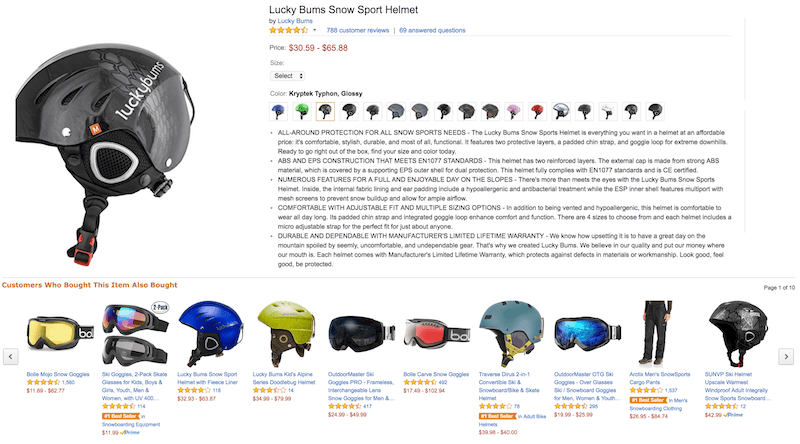

### Reedit: News Recommendations
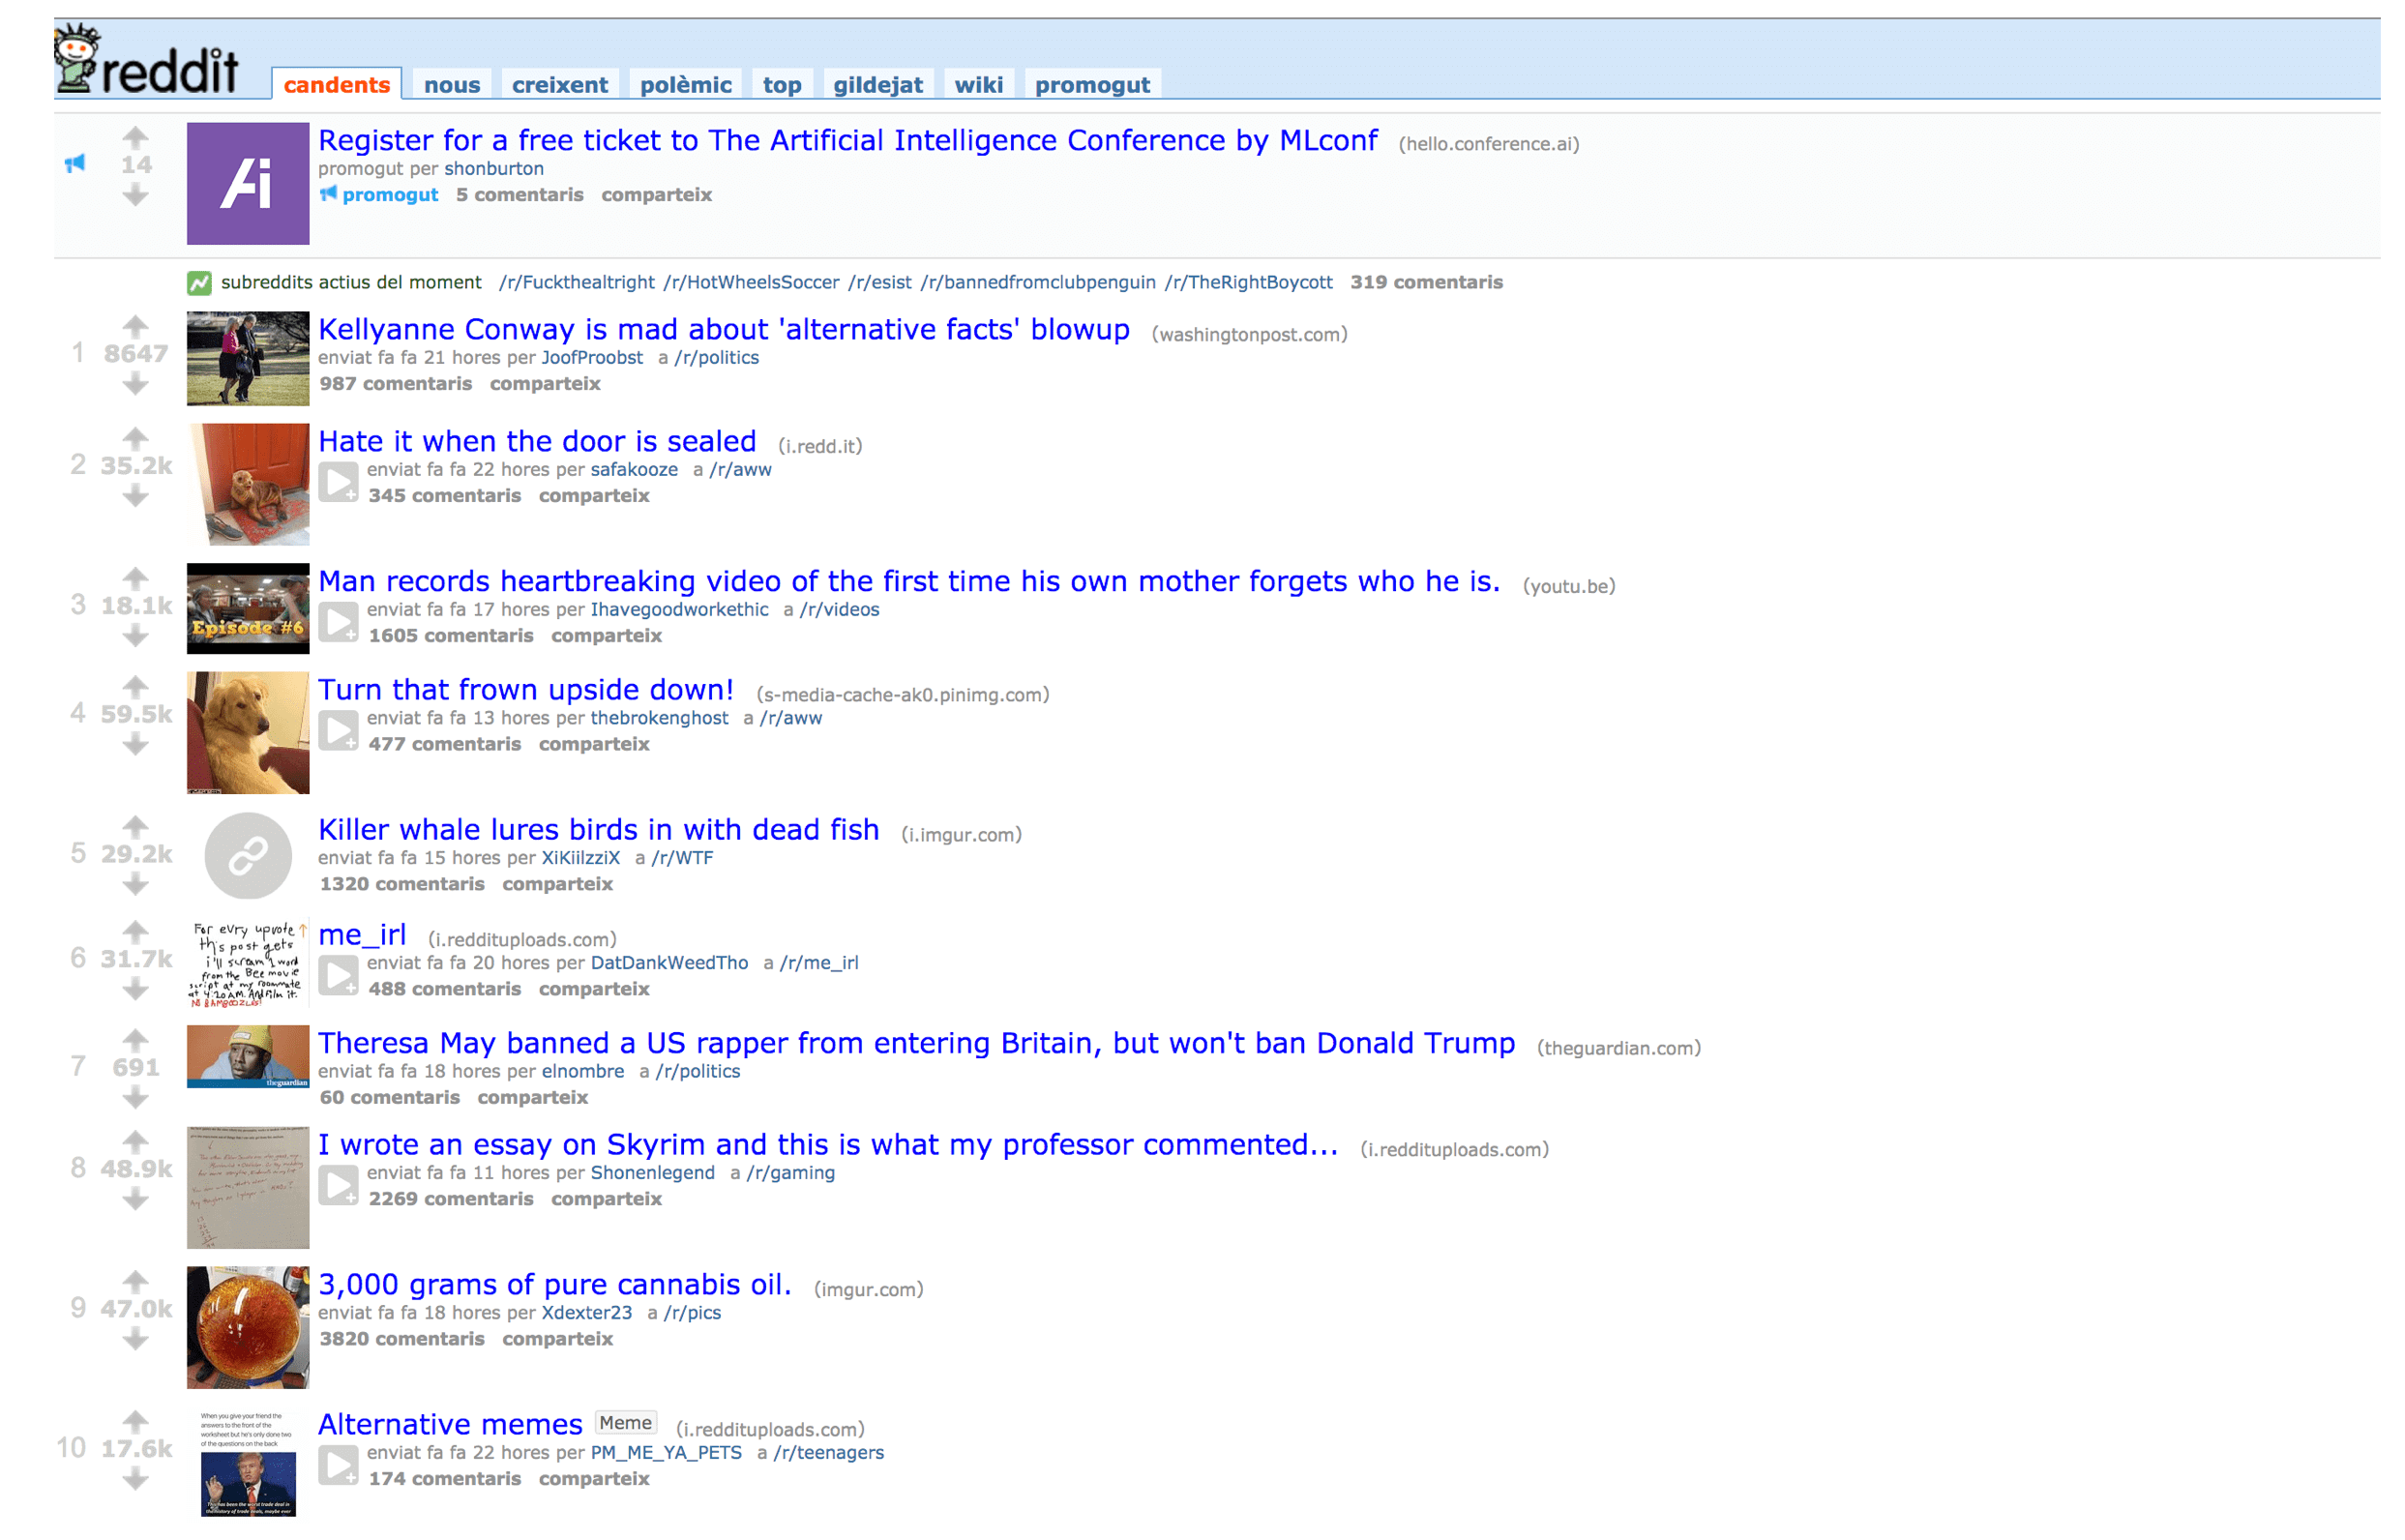

<p><b>Several</b> cases but <b>two main</b> approaches

1. Aggregated opinion recommenders
2. Basic product association recommenders

## Aggregated opinion recommenders

Usually, the problem posed as a learning to rank problem. But what seems to be straighfowrard becomes a really complicated question: <b>How do you rank your rated items and which logic to use to display them?</b>

In order to score/rank items we first have to <b>understand the business case</b>. Of course, several factors plays a role. For instance, 

* Which information do we have about the items? Bought / Seen / Rated / ... 
* From how many users do we have the info for a particular item 
* How old is that info? 


## EXAMPLE: Non-Personalised Recommender using MovieLens Dataset
We will work with the well known MovieLens dataset (http://grouplens.org/datasets/movielens/). This dataset was initially constructed to support participants in the Netflix Prize. Today, we can find several versions of this dataset with different amout of data, from 100k samples version to 20m sample version. Although performance on bigger dataset is expected to be better, we will work with the smallest dataset: MovieLens 100K Dataset (ml-100k-zip). Working with this lite version has the benefit of less computational costs


In [1]:
# With a unix machine the dataset can be downloaded with the following code:

#!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip 
#!unzip ml-100k.zip -d "data/"

If you are working with a windows machine, please go to the website and download the 100k version and extract it to the subdirectory named "data/ml-100k/"

Once you have downloaded and unzipped the file into a directory, you can create a DataFrame with the following code:

In [2]:
#NETFLIX REAL 50.000.000 usuaris and 100.000 items
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt

# Load Data set
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('data/ml-100k/u.user', sep='|', names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('data/ml-100k/u.data', sep='\t', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first three columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date']
movies = pd.read_csv('./data/ml-100k/u.item', sep='|', names=m_cols, usecols=range(3), encoding='latin-1')

# Construcció del DataFrame
data = pd.merge(pd.merge(ratings, users), movies)
data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]

print("The BD has "+ str(data.shape[0]) +" ratings")
print("The BD has ", data.user_id.nunique()," users")
print("The BD has ", data.movie_id.nunique(), " movies")
data.head()


The BD has 100000 ratings
The BD has  943  users
The BD has  1682  movies


,user_id,title,movie_id,rating,release_date,sex,age
0,196,Kolya (1996),242,3,24-Jan-1997,M,49
1,186,L.A. Confidential (1997),302,3,01-Jan-1997,F,39
2,22,Heavyweights (1994),377,1,01-Jan-1994,M,25
3,244,Legends of the Fall (1994),51,2,01-Jan-1994,M,28
4,166,Jackie Brown (1997),346,1,01-Jan-1997,M,47


If you explore the dataset in detail, you will see that it consists of:

100,000 ratings from 943 users of 1682 movies. Ratings are from 1 to 5.
Each user has rated at least 20 movies.
Simple demographic info for the users (age, gender, occupation, zip)

#### Top movies ranking. 
The simplest way to show the ranking is by using the mean rating.

In [3]:
mean_score = data.groupby(['title'])[['rating']].mean().rename(columns = {'rating': 'mean_rating'})
mean_score.sort_values(by='mean_rating',ascending=False).head(10)

,mean_rating
title,
They Made Me a Criminal (1939),5.0
Marlene Dietrich: Shadow and Light (1996),5.0
"Saint of Fort Washington, The (1993)",5.0
Someone Else's America (1995),5.0
Star Kid (1997),5.0
"Great Day in Harlem, A (1994)",5.0
Aiqing wansui (1994),5.0
Santa with Muscles (1996),5.0
Prefontaine (1997),5.0


#### What do you think about the output?

Now, let's show only ranking the mean rating but using only those movies with at least 20 ratings


In [4]:
size = data.groupby('title').size()
mean_score.loc[size>20].sort_values(by='mean_rating',ascending=False).head(10)

,mean_rating
title,
"Close Shave, A (1995)",4.491071
Schindler's List (1993),4.466443
"Wrong Trousers, The (1993)",4.466102
Casablanca (1942),4.456790
Wallace & Gromit: The Best of Aardman Animation (1996),4.447761
"Shawshank Redemption, The (1994)",4.445230
Rear Window (1954),4.387560
"Usual Suspects, The (1995)",4.385768
Star Wars (1977),4.358491


#### Any other idea?
#### How can you improve it?

## There are other measures like the **Damped Means**.

* **Problem:** There is low confidence with few ratings.
* **Solution:** Assume that, without evidence, everything is average.

$$
damped\_Means = \frac{\sum_u r_{u,i} + k \mu}{n + k}
$$

where \( k \) controls the strength of the required evidence.

In [5]:
k = 5
mean_score_movies  = data.groupby('movie_id')[['rating']].mean().rename(columns = {'rating': 'mean_rating'}).reset_index()
sum_ratings_movie = data.groupby('movie_id')[['rating']].sum().rename(columns = {'rating': 'num_ratings'}).reset_index()
sum_ratings_movie['num_ratings_factor'] = sum_ratings_movie['num_ratings'] + k *(data['rating'].mean())

count_ratings = data.groupby('movie_id')[['rating']].count().rename(columns = {'rating': 'count_rating'}).reset_index()
count_ratings['count_rating_factor'] = count_ratings['count_rating'] + k 

ratings_damped = pd.merge(sum_ratings_movie,
                         count_ratings[['movie_id','count_rating','count_rating_factor']],
                         on=['movie_id'],how='left')

ratings_damped['damped_mean']=ratings_damped['num_ratings_factor']/ratings_damped['count_rating_factor']

ratings_mean_damped=pd.merge(data[['title','movie_id']].drop_duplicates(),
                             ratings_damped[['movie_id','damped_mean']],
                             on=['movie_id'],how='left')

ratings_mean_damped = ratings_mean_damped.sort_values(by='damped_mean', ascending=False)
ratings_mean_damped.head()

,title,movie_id,damped_mean
200,Schindler's List (1993),318,4.450988
180,"Close Shave, A (1995)",408,4.449994
174,Casablanca (1942),483,4.438102
239,"Shawshank Redemption, The (1994)",64,4.429338
277,"Wrong Trousers, The (1993)",169,4.428043



## Ranking Cosiderations

+ Confidence
 - How confident are we that this item is good?
 
+ Risk tolerance
 - High-risk, high-reward
 - Conservative recommendations

+ Domain and business considerations
 - Age
 - System goals

**REDDIT:** Old stories are not interesting even though they might have a high net upvotes score! How does Reddit deal with this?

$$ \log_{10}\max(1, |U - D|) + \frac{\text{sign}(U - D) \cdot t_{\text{post}}}{45000} $$

where $ U $ is the number of upvotes and $ D $ is the number of downvotes.

* In Reddit, time and votes were treated independently.
* The log term has a damping effect for votes. The idea is that votes 11 to 100 should have the same influence as votes 1 to 10. Obviously, a post with 1000 votes should be better than a post with 1 vote, but is a post with 2000 votes much better than one with 1000 votes? The log decreases marginal values for later votes.
* The $ \text{sign}(U - D) $ is useful to bury any negative items (as Reddit wants only to show the popular ones!).


<p><b>HACKERS NEWS:</b> </p>

$$ \frac{(U - D  +1)^\alpha}{(t_{now} - t_{post})^\gamma} P $$

* Numerator is related to popularity
* Denominator is realted to the age factor with a gravity effect with the $\gamma$ parameter
* $P$ is a penalty term for each new

### It was really famous and then it started getting worse.  <span style="color:red">Why???</span>

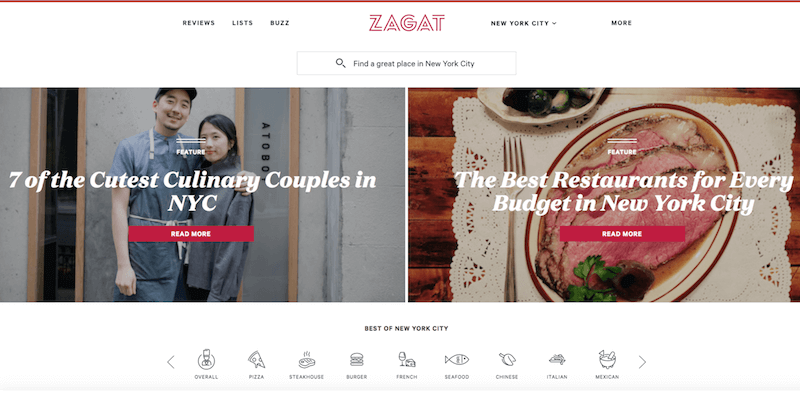


Problems with ratings:
* Are ratings reliables and accurate?
* Do the users change his/her preferences?
* What is a mean rating?

## Basic product association recommenders
People who buy X also buy Y.


#### Case 1

In [6]:
#Let's read a dataset which contains several market baskets lists

# read data/grocieries.csv
def union(a, b):
    """ return the union of two lists """
    return list(set(a) | set(b))

market_data = []
cont = 0
items = []
with open("data/groceries.csv") as f:
    for l in f:
        market_data.append(l.rstrip().split(','))
        items = union(items,l.rstrip().split(','))

print("Number of different items", len(items))
print("Number of rows ", len(market_data))


print("An example:", market_data[3])
print("An example:", market_data[0:3])

Number of different items 171
Number of rows  9835
An example: ['pip fruit', 'yogurt', 'cream cheese ', 'meat spreads']
An example: [['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'], ['tropical fruit', 'yogurt', 'coffee'], ['whole milk']]


One of the most simple ways to found association between product could be obtained as follows: 


$$score(Y|X) = \frac{X \ and \ Y}{X}$$

In [7]:
# Which is the top associated product with "yogurt"?
## What are we asking: "What is the probability of product X, given that we bought yogurt", and then we find the highest number
def top_associated_products(data: list, 
                            product: str,
                            N: int = 5):
    d = {}
    times = 0
    for l in data:
        if product in l:
            times = times + 1
            for i in l:
                if i != product: 
                    if(i in d):
                        d[i] += 1.0
                    else:
                        d[i] = 1.0

    for k in d:
        d[k] =   d[k] / times
    sorted_list=sorted(d.items(), key=lambda x: x[1],reverse=True)
    return sorted_list[:N]

s = top_associated_products(market_data, 'yogurt',N = 10)
print(s)

[('whole milk', 0.40160349854227406), ('other vegetables', 0.3112244897959184), ('rolls/buns', 0.24635568513119532), ('tropical fruit', 0.2099125364431487), ('soda', 0.19606413994169097), ('root vegetables', 0.18513119533527697), ('bottled water', 0.16472303206997085), ('citrus fruit', 0.1552478134110787), ('whipped/sour cream', 0.14868804664723032), ('sausage', 0.14067055393586006)]


In [8]:
# Which is the top associated prouct with "rice"?
s = top_associated_products(market_data, 'rice',N = 3)
print(s)

# Which is the top associated prouct with "rum"?
s = top_associated_products(market_data, 'rum',N = 3)
print(s)

# Which is the top associated prouct with "whole milk"?
s = top_associated_products(market_data, 'whole milk',N = 3)
print(s)

[('whole milk', 0.6133333333333333), ('other vegetables', 0.52), ('root vegetables', 0.41333333333333333)]
[('whole milk', 0.38636363636363635), ('other vegetables', 0.3409090909090909), ('tropical fruit', 0.20454545454545456)]
[('other vegetables', 0.29287703939514526), ('rolls/buns', 0.2216474333465977), ('yogurt', 0.2192598487863112)]


#### What happens? Is it a good measure? It has a problem with popular items...


Let's check this other formula:
$$score(Y|X) = \frac{ \frac{X \ and \ Y}{X}} {  \frac{!X \ and \ Y}{!X} }  $$

In [9]:
from collections import defaultdict

def top_associated_products2(data: list, 
                             product: str, 
                             N: int = 5):
    
    d, d_not, d_yes = {}, {}, {}
    d = defaultdict(lambda: 0, d)
    d_not = defaultdict(lambda: 0, d_not)
    times, times_not = 0, 0
    for l in data:
        if product in l:
            times = times + 1
            for i in l:
                if i != product: 
                    if(i in d_yes):
                        d_yes[i] += 1.0
                    else:
                        d_yes[i] = 1.0
        else:
            times_not = times_not + 1
            for i in l:
                if(i in d_not):
                    d_not[i] += 1.0
                else:
                    d_not[i] = 1.0
                        
    for k in d_yes:
        if(d_not[k] == 0):
            d[k] = 0
        else:
            d[k] =  ( d_yes[k] *times_not) / (times * d_not[k])
    sorted_list=sorted(d.items(), key=lambda x: x[1],reverse=True)
    return sorted_list[:N]

In [10]:
s = top_associated_products2(market_data, 'yogurt',N = 3)
print(s)

# Which is the top associated prouct with "rice"?
s = top_associated_products2(market_data, 'rice',N = 3)
print(s)

# Which is the top associated prouct with "rum"?
s = top_associated_products2(market_data, 'rum',N = 3)
print(s)

[('kitchen utensil', 6.168367346938775), ('preservation products', 6.168367346938775), ('meat spreads', 4.626275510204081)]
[('decalcifier', 20.02051282051282), ('canned fruit', 18.590476190476192), ('organic products', 18.590476190476192)]
[('artif. sweetener', 14.834848484848484), ('specialty vegetables', 13.907670454545455), ('cooking chocolate', 9.271780303030303)]


#### Let's check this last formula:
$$ score(Y|X) = \frac{P(X \ and \ Y)}{P(X)P(Y) }   $$

In [11]:
def top_associated_products3(data: list, 
                             product: str, 
                             N: int = 5):
    
    d , times = {}, {}
    d = defaultdict(lambda: 0, d)
    times = defaultdict(lambda: 0, times)
    for l in data:
        for item in l:
            if item in times: #already exist
                times[item] += 1
            else:
                times[item] =1
        if product in l:
            for i in l:
                if i != product: 
                    if(i in d):
                        d[i] += 1.0
                    else:
                        d[i] = 1.0
                        
    for k in d:
        d[k] =  ( d[k] /len(market_data) ) / ((times[k]/len(market_data)) * times[product] /(len(market_data)))
        
    sorted_list=sorted(d.items(), key=lambda x: x[1],reverse=True)
    return sorted_list[:N]

In [12]:
s = top_associated_products3(market_data, 'yogurt',N = 3)
print(s)

# Which is the top associated prouct with "rice"?
s = top_associated_products3(market_data, 'rice',N = 3)
print(s)

# Which is the top associated prouct with "rice"?
s = top_associated_products3(market_data, 'rum',N = 3)
print(s)

s = top_associated_products3(market_data, 'baby food',N = 3)
print(s)

[('baby food', 7.168367346938775), ('kitchen utensil', 3.5841836734693877), ('preservation products', 3.5841836734693877)]
[('decalcifier', 17.484444444444446), ('canned fruit', 16.391666666666666), ('organic products', 16.391666666666666)]
[('artif. sweetener', 13.970170454545455), ('specialty vegetables', 13.148395721925132), ('cooking chocolate', 8.940909090909091)]
[('finished products', 153.671875), ('soups', 146.7910447761194), ('cake bar', 75.65384615384615)]


#### **EXERCISE 1:**
Let's apply Association Rules on MovieLens Dataset
</div>

Which is the top association with "Star Wars (1977)"?

In [13]:
data.head()
movies_data = data.groupby('user_id')['title'].agg(list).reset_index()


top_associated_products(movies_data['title'].to_list(), 'Groundhog Day (1993)', N=5)
top_associated_products2(movies_data['title'].to_list(), 'Groundhog Day (1993)', N=5)
top_associated_products3(movies_data['title'].to_list(), 'Groundhog Day (1993)', N=5)

[('Police Story 4: Project S (Chao ji ji hua) (1993)', 35.125),
 ('Fire on the Mountain (1996)', 35.125),
 ('Power 98 (1995)', 35.125),
 ('Love and Death on Long Island (1997)', 35.125),
 ('Great Day in Harlem, A (1994)', 35.125)]

## APRIORI Algorithm
Typically, association rules are considered interesting if they satisfy both a minimum support threshold and a minimum confidence threshold

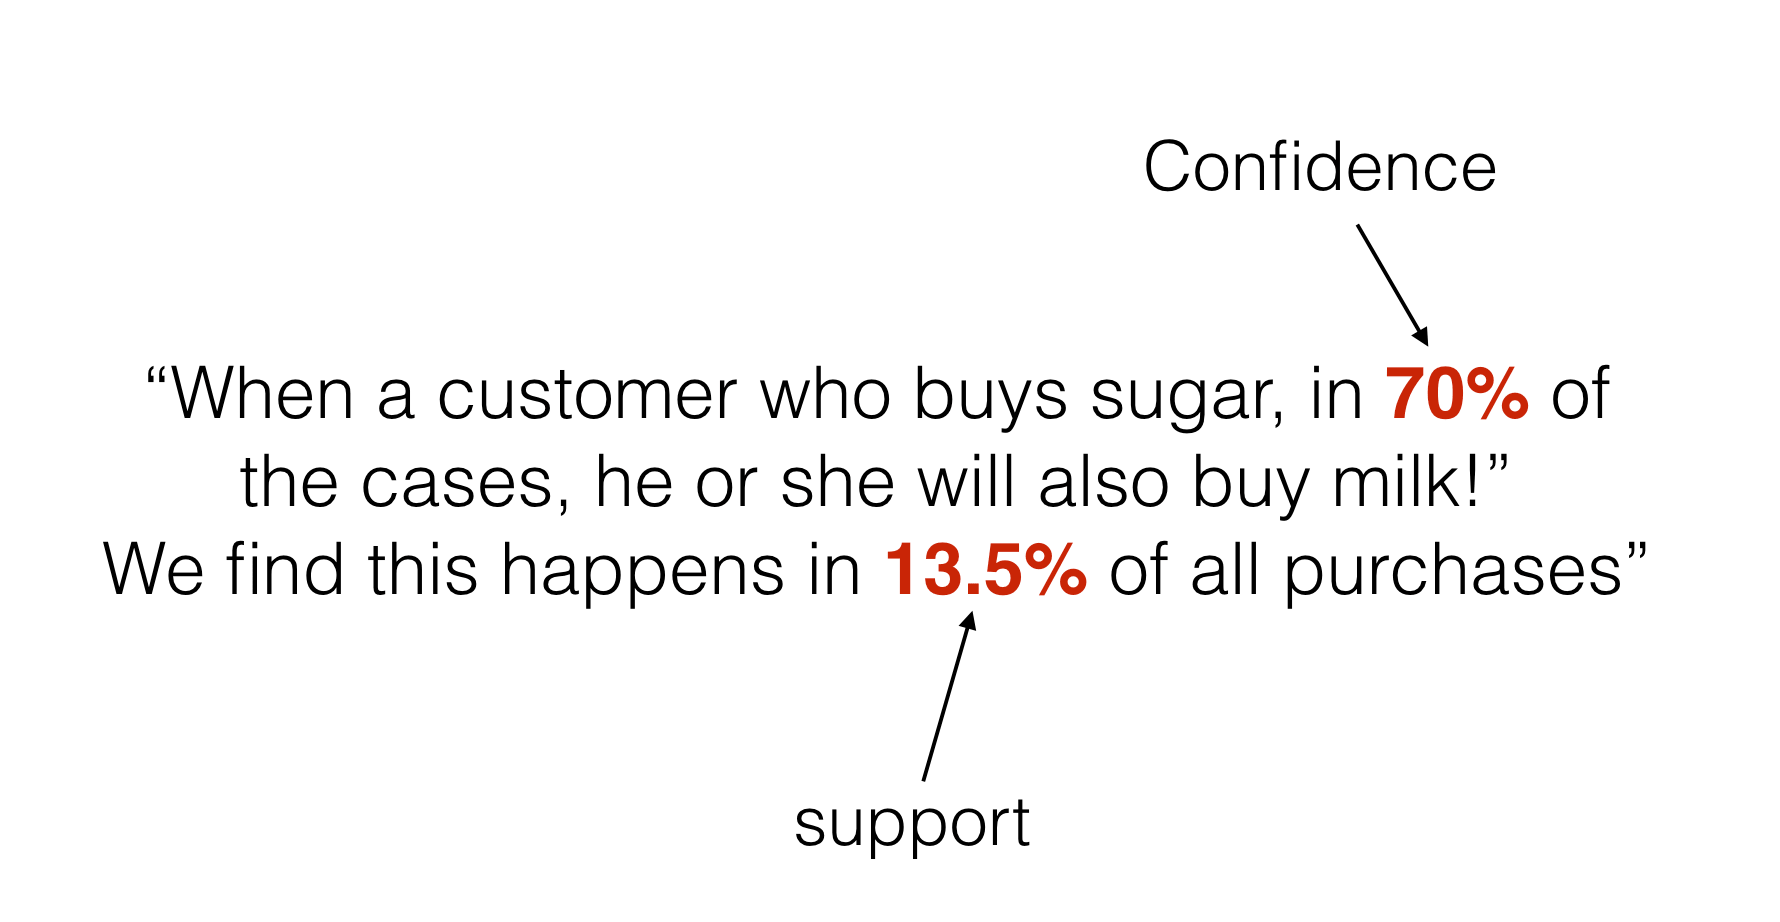

<b>Apriori principle</b>: Any subset of a frequent itemset must be frequent
> Step 1: Find the frequent itemsset: the set of items that have minimum support.
> -  A subset of a frequent itemset must also be a frequent itemset  i.e. if {1,2} is a frequent itemset, both {1} and {2} should be a frequent itemset
> - Iteratively find frequent itemsets with cardinality from 1 to k (k-itemset)

> Step 2: Use the frequent itemsets to generate association rules

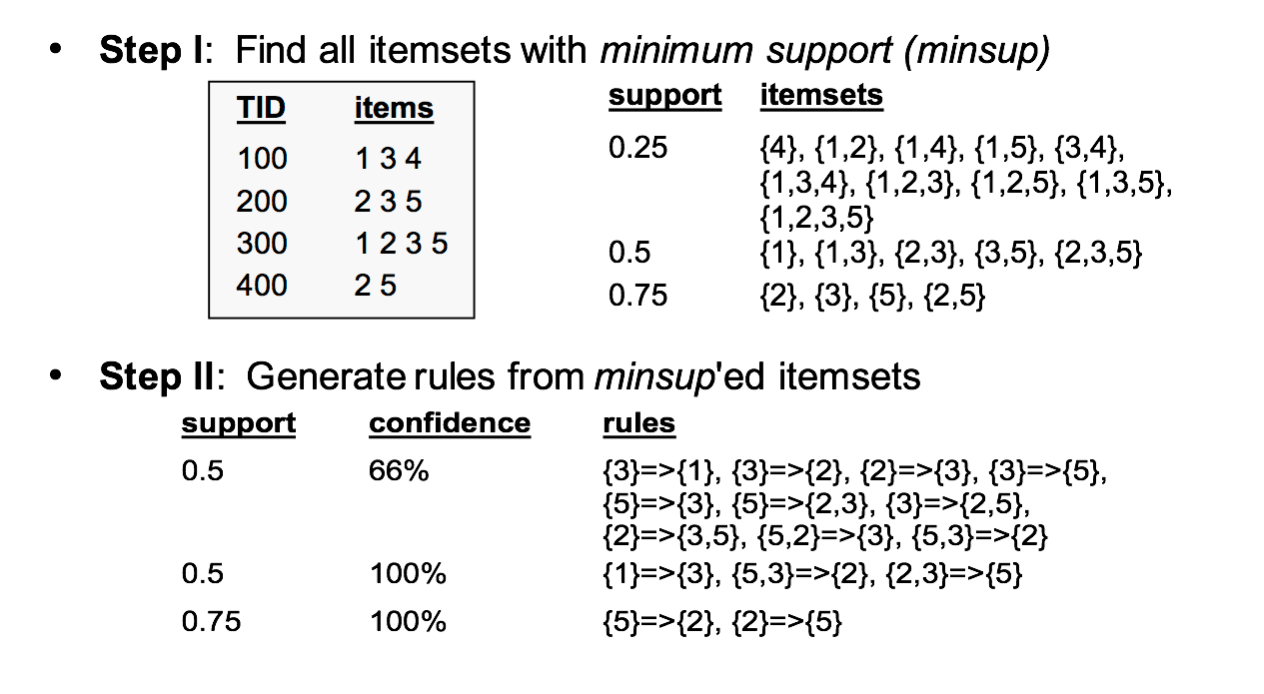

Reference : 
http://www.vldb.org/conf/1994/P487.PDF


**EXERCISE 2:**
Implement Apriori Method and apply it to Basket Case dataset
</div>

**EXERCISE 3:**
Apply Apriori method to movielens dataset
</div>
